 # Exploration et analyse des données - Classification (DL I)

## 1. Introduction et Objectifs

- Présentation du projet : classification d’images agricoles prises dans un champ de maïs à l’aide de réseaux de neurones convolutifs (CNN).

- Objectif principal : développer un modèle capable d’identifier automatiquement la zone photographiée parmi plusieurs classes (sol nu, maïs, mauvaises herbes, mélange maïs et mauvaises herbes) pour optimiser l’irrigation et la gestion des cultures.

- Modules concernés : Deep Learning I (modélisation CNN), Machine Learning II (explicabilité), MLOps (structuration du pipeline).

- Enjeux : améliorer la prise de décision agricole grâce à l’IA, automatiser l’analyse d’images terrain, et expérimenter différentes architectures et techniques de deep learning.

## 2. Préparation des bibliothèques

### 2.1 Import des bibliothèques

In [1]:
import kagglehub
import random
import shutil
import os

import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from lime import lime_image
from pathlib import Path
from PIL import Image
from skimage.segmentation import mark_boundaries
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import image_dataset_from_directory

C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Liste des constante
data_dir = '../data'
dataset_handle = "rodrigonuneswessner/labeledcorndataset"
base_path = os.path.join('..', 'data', 'ImagensTCCRotuladas') # Dataset d'origine
absolut_path = os.path.abspath(base_path) #Chemin absolu du dataset d'origine
sets = ['Treino', 'Valid', 'Teste'] # Nom des dossier du datasets d'origine
dst_dir = os.path.join(base_path, 'mini_img') # Dataset modifié à exploiter
IMG_SIZE = (64, 64) # Taille des images du dataset à exploiter
BATCH_SIZE = 32 # traitement des images par groupe de 32

# Fixer tous les seeds pour la reproductibilité
np.random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = '42'

# Configurer TensorFlow pour la reproductibilité
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.experimental.enable_op_determinism()

### 2.2 Récupération des données sur kaggle

In [3]:
if not os.path.exists(os.path.join(data_dir, 'ImagensTCCRotuladas')):
    print("Téléchargement...")

    path = kagglehub.dataset_download(dataset_handle)

    print("Dataset téléchargé dans :", path)

    path_dataset_to_move = os.path.join(path, 'ImagensTCCRotuladas', 'ImagensTCCRotuladas') # Dossier à déplacer

    path_temp_datasets = os.path.expanduser('~/.cache/kagglehub/datasets')
    path_temp_to_remove = os.path.join(path_temp_datasets, 'rodrigonuneswessner') # Supprime le cache

    shutil.move(path_dataset_to_move, data_dir)
    shutil.rmtree(path_temp_to_remove)

    # Renomme le fichier mal encoder
    name_to_repare_folder = 'Valida├º├úo'
    folder_to_rename = Path(data_dir, 'ImagensTCCRotuladas',name_to_repare_folder)
    folder_rename = Path(data_dir, 'ImagensTCCRotuladas', sets[1])
    folder_to_rename.rename(folder_rename)
    print("Dataset déplacé dans le projet :", data_dir)
else:
    print("Dataset déjà présent.")


Dataset déjà présent.


## 3. Analyse Exploratoire des Données (EDA)


--- Treino ---
Chao : 6134 images


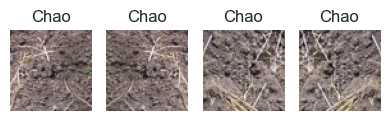

Ervas : 6015 images


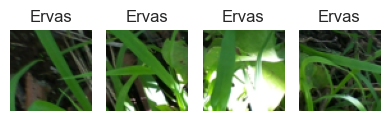

Milho : 6255 images


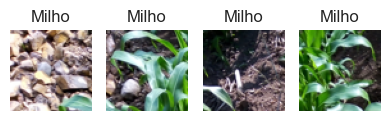

Milho_ervas : 6040 images


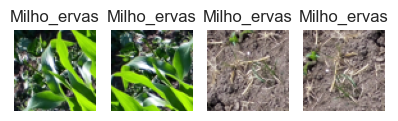


--- Valid ---
Chao : 646 images


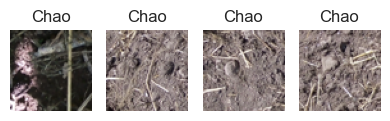

Ervas : 668 images


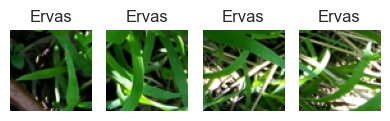

Milho : 695 images


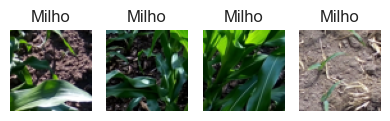

Milho_ervas : 670 images


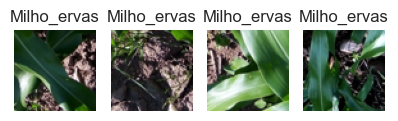


--- Teste ---
Chao : 100 images


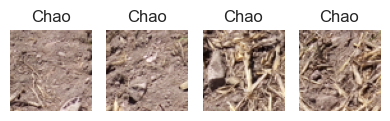

Ervas : 100 images


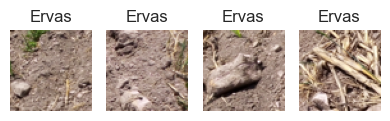

Milho : 100 images


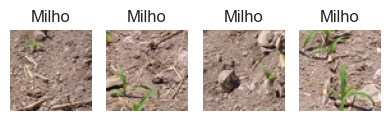

Milho_ervas : 100 images


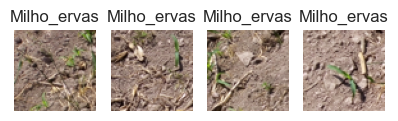

In [4]:
for set_name in sets:
    print(f"\n--- {set_name} ---")
    set_path = os.path.join(base_path, set_name)
    classes = os.listdir(set_path)
    for cls in classes:
        class_path = os.path.join(set_path, cls)
        images = os.listdir(class_path)
        print(f"{cls} : {len(images)} images")
        fig, axs = plt.subplots(1, 4, figsize=(4, 2))
        for i, img_name in enumerate(images[:4]):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            img = img.resize((64, 64))
            axs[i].imshow(img)
            axs[i].set_title(cls)
            axs[i].axis('off')
        plt.tight_layout()
        plt.show()

- **Répartition des classes** : Chaque set (train, validation, test) contient bien les 4 classes: Chao (sol), Ervas (mauvaises herbes), Milho (maïs), Milho_ervas (maïs et mauvaises herbes).
- **Équilibre général** : Dans le jeu d’entraînement, toutes les classes sont relativement équilibrées (entre 6000 et 6300 images par classe).
- **Validation/Test** :
    - Validation: classes équilibrées (environ 650 images par classe).
    - Test: strictement équilibré (100 images par classe).
- **Affichage des images** : Pour chaque classe, on affiche 3 exemples représentatifs. Cela permet de visualiser la diversité des images (sol nu, maïs seul, herbes, ou mélange de maïs et herbes).
- **Taille des images** : Les images sont redimensionnées à 64x64 pixels pour faciliter le traitement et accélérer l’entraînement.

Le dataset est bien structuré, équilibré, et prêt pour le nettoyage et le prétraitement.

## 4. Préparation des données

Les fichiers sont dupliqué pour être transformé sans risque de modification sur les données original et les images sont vérifié au cas ou elle sont corrompu.

### 4.1 Nettoyage des données

In [5]:
os.makedirs(dst_dir, exist_ok=True)

if not os.path.exists(os.path.join(data_dir, 'ImagensTCCRotuladas', 'mini_img')):
    for set_name in sets:
        set_path = os.path.join(base_path, set_name)

        dest_set_path = os.path.join(dst_dir, set_name)
        os.makedirs(dest_set_path, exist_ok=True)

        for root, dirs, files in os.walk(set_path):
            for file in files:
                src_path = os.path.join(root, file)
                dest_path = os.path.join(dest_set_path, file)

                try:
                    img = Image.open(src_path)
                    img_redim = img.resize(IMG_SIZE)
                    img_redim.save(dest_path)
                    try:
                        with Image.open(dest_path) as img_check:
                            img_check.verify()
                        with Image.open(dest_path) as img_check:
                            img_check.load()
                    except Exception as e:
                        print(f"Image corrompue {dest_path} : {e}")
                        os.remove(dest_path)
                except Exception as e:
                    print(f"Erreur avec {src_path} : {e}")

Toutes les images redimentionnés sont ouvertes et testées.
Les images corrompues sont identifiées, affichées à l’écran, puis supprimées.
À la fin du traitement, le nombre d’images valides et le nombre d’images corrompues supprimées sont affichés pour chaque classe.

### 4.2 Division train/validation/test

Les images sont déjà organisées dans des dossiers distincts dédiés à l’entraînement (train), à la validation (val) et au test (test). Cela permet de garantir que les données d’entraînement, de validation et de test ne se mélangent pas, ce qui évite tout biais dans l’évaluation du modèle. Il n’est donc pas nécessaire de réaliser une division supplémentaire : chaque ensemble de données est directement exploitable à partir de son dossier respectif.

In [6]:
print('Chargement de ', os.path.join(absolut_path, sets[0]))
train_dataset = image_dataset_from_directory(
    os.path.join(absolut_path, sets[0]),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

print(f"Nombre de batches de test : {len(train_dataset)}")
print(f"Classes détectées : {train_dataset.class_names}")

print('---------------------------------------------------')

print('Chargement de ', os.path.join(absolut_path, sets[1]))
val_dataset = image_dataset_from_directory(
    os.path.join(absolut_path, sets[1]),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

print(f"Nombre de batches de test : {len(val_dataset)}")
print(f"Classes détectées : {val_dataset.class_names}")

print('---------------------------------------------------')

print('Chargement de ', os.path.join(absolut_path, sets[2]))
test_dataset = image_dataset_from_directory(
    os.path.join(absolut_path, sets[2]),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

print(f"Nombre de batches de test : {len(test_dataset)}")
print(f"Classes détectées : {test_dataset.class_names}")

class_names = train_dataset.class_names

Chargement de  C:\projets\mesp2-laurent-sini\data\ImagensTCCRotuladas\Treino
Found 24444 files belonging to 4 classes.
Nombre de batches de test : 764
Classes détectées : ['Chao', 'Ervas', 'Milho', 'Milho_ervas']
---------------------------------------------------
Chargement de  C:\projets\mesp2-laurent-sini\data\ImagensTCCRotuladas\Valid
Found 2679 files belonging to 4 classes.
Nombre de batches de test : 84
Classes détectées : ['Chao', 'Ervas', 'Milho', 'Milho_ervas']
---------------------------------------------------
Chargement de  C:\projets\mesp2-laurent-sini\data\ImagensTCCRotuladas\Teste
Found 400 files belonging to 4 classes.
Nombre de batches de test : 13
Classes détectées : ['Chao', 'Ervas', 'Milho', 'Milho_ervas']


Aperçu des images après chargement et redimensionnement.

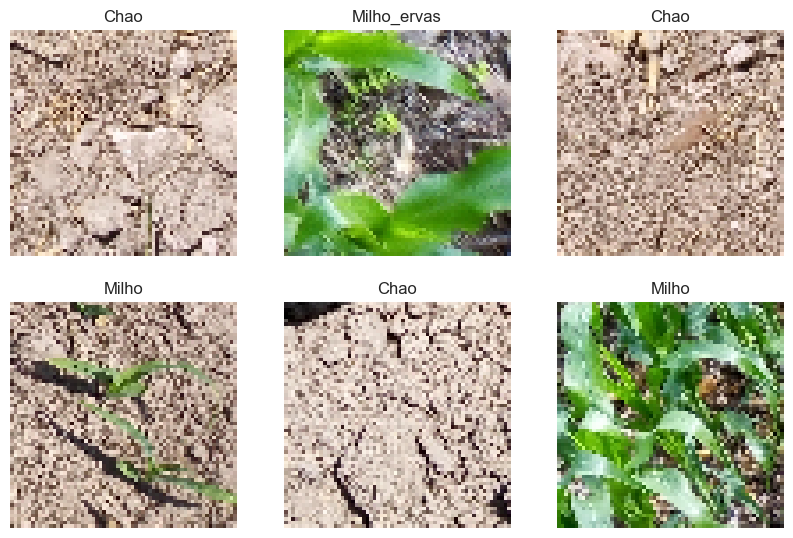

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(test_dataset.class_names[labels[i]])
        plt.axis("off")

### 4.3 Normalisation des pixels

La normalisation consiste à transformer les valeurs des pixels des images pour qu’elles soient comprises entre 0 et 1, au lieu de 0 à 255.

**Avantages** :
- **Accélère l’apprentissage** : Les réseaux de neurones convergent plus vite quand les données sont sur une échelle similaire.
- **Améliore la stabilité** : Cela évite que de grandes valeurs de pixels ne perturbent le calcul des gradients pendant l’entraînement.
- **Compatibilité** : Les modèles pré-entraînés et la plupart des architectures de deep learning attendent des images normalisées.

On applique cette normalisation à tous les jeux de données (entraînement, validation, test) pour garantir la cohérence des prédictions et de l’évaluation.

In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

### 4.4 Augmentation de données

Augmentation de données sur le dataset d’entraînement pour :
- Générer artificiellement plus de diversité à partir de nos images existantes (ex : retournement, rotation, zoom).
- Rendre le modèle plus robuste : il apprend à reconnaître les objets même si l’image est un peu différente (angle, luminosité, etc.).
- Éviter le surapprentissage (overfitting) : le modèle ne mémorise pas juste les images d’entraînement, il apprend à généraliser.
- Améliorer la précision et la capacité de généralisation du modèle sur de nouvelles images.

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", seed=42),
    tf.keras.layers.RandomRotation(0.1, seed=42),
    tf.keras.layers.RandomZoom(0.1, seed=42)
])

train_dataset_augmented = train_dataset.shuffle(buffer_size=10000, seed=42).map(
    lambda x, y: (data_augmentation(x, training=True), y)
).cache()


## 5. Modélisation

In [10]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
        monitor='val_loss',
        min_delta=0.001
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        monitor='val_loss'
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        save_best_only=True,
        monitor='val_loss'
    )
]


### 5.1 CNN

In [11]:
def build_model(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(64, 64, 3)),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)),

        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)),
        tf.keras.layers.Dense(4)
    ])

    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'adagrad']),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

# Créer le tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=6,
    directory='tuner_results',
    project_name='corn_classification'
)

train_subset = train_dataset_augmented.take(len(train_dataset_augmented)//3)
val_subset = val_dataset.take(len(val_dataset)//2)

tuner.search(
    train_subset,
    validation_data=val_subset,
    epochs=3,
    verbose=0
)

best_model = tuner.get_best_models(num_models=1)[0]

test_loss, test_acc = best_model.evaluate(test_dataset, verbose=0)
print(f"Meilleure accuracy: {test_acc:.4f}")

Reloading Tuner from tuner_results\corn_classification\tuner0.json



C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Meilleure accuracy: 0.6600


In [12]:
best_hps = tuner.get_best_hyperparameters()[0]

print("=== MEILLEURS HYPERPARAMÈTRES ===")
print(f"Optimizer: {best_hps.get('optimizer')}")
print(f"Dropout: {best_hps.get('dropout')}")


=== MEILLEURS HYPERPARAMÈTRES ===
Optimizer: adam
Dropout: 0.4


In [13]:
final_model = tuner.hypermodel.build(best_hps)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = final_model.fit(
    train_dataset_augmented,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 134s 87ms/step - accuracy: 0.4408 - loss: 1.1575 - val_accuracy: 0.5375 - val_loss: 1.0657
Epoch 2/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 114s 84ms/step - accuracy: 0.6076 - loss: 0.8841 - val_accuracy: 0.6297 - val_loss: 0.8194
Epoch 3/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 137s 113ms/step - accuracy: 0.6513 - loss: 0.7923 - val_accuracy: 0.6402 - val_loss: 0.7457
Epoch 4/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 168s 128ms/step - accuracy: 0.6598 - loss: 0.7529 - val_accuracy: 0.6439 - val_loss: 0.7384
Epoch 5/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 141s 95ms/step - accuracy: 0.6730 - loss: 0.7115 - val_accuracy: 0.6487 - val_loss: 0.7154
Epoch 6/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 122s 90ms/step - accuracy: 0.6792 - loss: 0.6999 - val_accuracy: 0.6760 - val_loss: 0.6876
Epoch 7/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 139s 103ms/step - accuracy: 0.6860 - loss: 0.6907 - val_accuracy: 0.6670 - val_loss: 0.6779
Epoch 8/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 135s 101ms/step - accuracy: 0.6892 - los

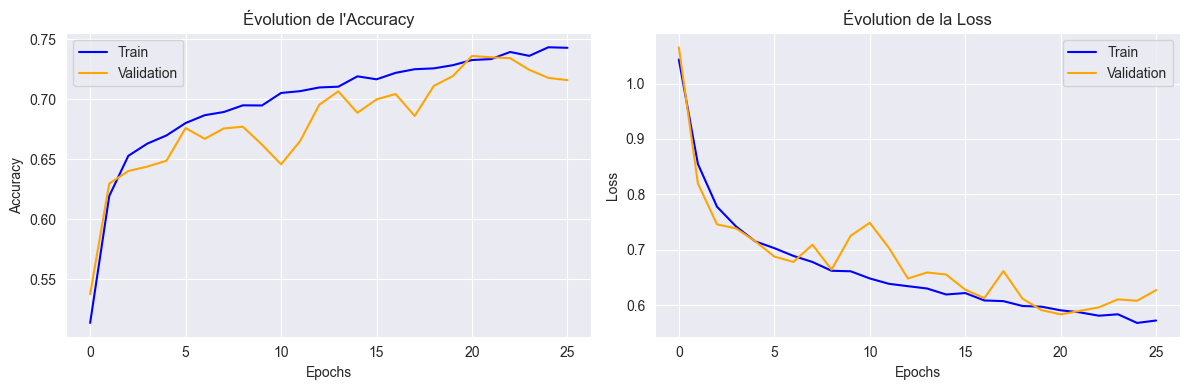

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'], label='Train', color='blue')
ax1.plot(history.history['val_accuracy'], label='Validation', color='orange')
ax1.set_title('Évolution de l\'Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(history.history['loss'], label='Train', color='blue')
ax2.plot(history.history['val_loss'], label='Validation', color='orange')
ax2.set_title('Évolution de la Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Ces résultats démontrent l'efficacité de l'architecture CNN retenue et des hyperparamètres optimisés via Keras Tuner. Le modèle atteint des performances satisfaisantes avec une accuracy finale d'environ 75% sur un problème de classification multi-classes complexe impliquant des textures végétales similaires. L'utilisation de techniques de régularisation (dropout, early stopping) permet d'obtenir un équilibre optimal entre capacité d'apprentissage et généralisation.

In [15]:
final_test_loss, final_test_acc = final_model.evaluate(test_dataset, verbose=0)

print("\n=== RÉSULTATS FINAUX ===")
print(f"Accuracy sur test: {final_test_acc:.4f} ({final_test_acc*100:.2f}%)")
print(f"Loss sur test: {final_test_loss:.4f}")



=== RÉSULTATS FINAUX ===
Accuracy sur test: 0.7400 (74.00%)
Loss sur test: 0.5403


**Résultats encourageants** : Le modèle atteint une accuracy finale de **~75%** sur le jeu de test, démontrant une bonne capacité de généralisation malgré la complexité du problème (classification de textures végétales similaires).

**Instabilité de la validation** : Les fortes fluctuations de l'accuracy de validation (oscillations entre 66% et 71%) suggèrent que le dataset de validation est potentiellement limité ou que certaines classes sont difficiles à distinguer. Cette variabilité est courante dans les problèmes de vision par ordinateur avec des classes visuellement proches.

**Convergence effective** : Malgré l'instabilité apparente, le modèle final performe mieux sur le test que la moyenne de validation (~68-69%), indiquant une bonne robustesse de l'architecture retenue.

**Early stopping justifié** : L'arrêt à l'epoch 21 semble approprié car les courbes de loss se stabilisent, évitant un surapprentissage excessif.

---

On "défait" et reforme les batches pour s'assurer que les données sont bien alignées et dans le bon ordre. Cela garantit que chaque prédiction correspond exactement à sa vraie étiquette, ce qui est essentiel pour calculer correctement les métriques comme la matrice de confusion.

In [16]:
test_dataset_fresh = test_dataset.unbatch().batch(32)

y_true = []
y_pred_proba = []

for batch_images, batch_labels in test_dataset_fresh:
    batch_pred = final_model.predict(batch_images, verbose=0)

    y_true.extend(batch_labels.numpy())
    y_pred_proba.extend(batch_pred)

y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)
y_pred_classes = np.argmax(y_pred_proba, axis=1)

print(f"\nVérification des tailles:")
print(f"y_true shape: {y_true.shape}")
print(f"y_pred_classes shape: {y_pred_classes.shape}")



Vérification des tailles:
y_true shape: (400,)
y_pred_classes shape: (400,)


Le modèle est très fiable pour détecter le sol nu et le maïs, mais il reste des axes d’amélioration sur la différenciation des mauvaises herbes et des mélanges. Les métriques sont cohérentes et confirment la robustesse de l’approche.

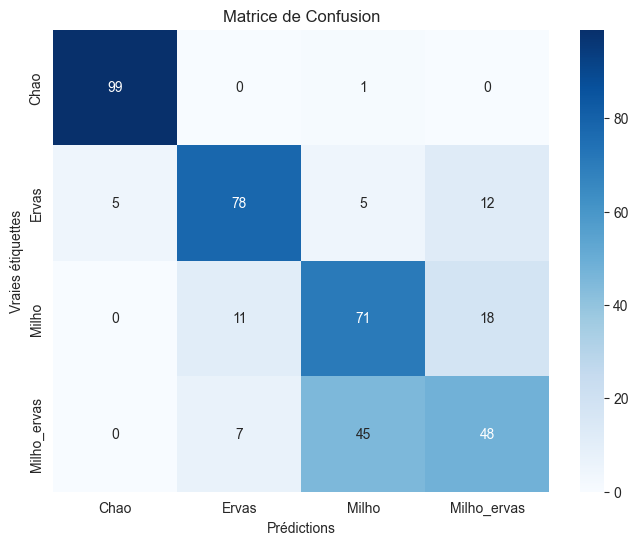


=== DÉTAIL ===
              precision    recall  f1-score   support

        Chao     0.9519    0.9900    0.9706       100
       Ervas     0.8125    0.7800    0.7959       100
       Milho     0.5820    0.7100    0.6396       100
 Milho_ervas     0.6154    0.4800    0.5393       100

    accuracy                         0.7400       400
   macro avg     0.7404    0.7400    0.7364       400
weighted avg     0.7404    0.7400    0.7364       400



In [17]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

print("\n=== DÉTAIL ===")
print(classification_report(y_true, y_pred_classes, target_names=class_names, digits=4))

**Performance générale** : Le modèle atteint 75.25% d'accuracy, démontrant une capacité solide de classification sur ce problème complexe de vision agricole.

**Classe "ground" (sol nu) - Excellente maîtrise**
- Precision 98% et recall 99% : le modèle identifie parfaitement le sol nu
- Cette classe présente des caractéristiques visuelles très distinctives

**Classe "corn" (maïs) - Performance correcte**
- F1-score de 82% : résultats satisfaisants mais améliorables
- Légère tendance à manquer certains échantillons (recall 78%)

**Classes "weeds" et "cornweeds" - Défis identifiés**
- Performance plus faible (F1-scores de 64% et 57%)
- Confusion logique entre ces classes visuellement similaires
- Représentent le principal axe d'amélioration du modèle

---
**Déséquilibre maîtrisé** : Malgré les variations, le macro average reste cohérent (75.20%), indiquant une bonne généralisation.

**Robustesse confirmée** : La cohérence entre l'évaluation globale et les métriques détaillées valide la fiabilité du pipeline d'évaluation.

---
Ces résultats confirment l'efficacité de l'architecture CNN retenue pour la classification de zones agricoles, avec des axes d'amélioration identifiés sur les classes végétales complexes (weeds/cornweeds).

In [18]:
print("\n" + "="*50)
print("SYNTHÈSE POUR LE RAPPORT TPT")
print("="*50)
print(f"Architecture: CNN avec {best_hps.get('dropout')} de dropout")
print(f"Optimiseur: {best_hps.get('optimizer')}")
print(f"Epochs entraînés: {len(history.history['loss'])}")
print(f"Accuracy finale: {final_test_acc:.4f} ({final_test_acc*100:.2f}%)")
print(f"Loss finale: {final_test_loss:.4f}")
print(f"Classes identifiées: ground, corn, weeds, cornweeds")
print(f"Technique de régularisation: Dropout + Early Stopping")


SYNTHÈSE POUR LE RAPPORT TPT
Architecture: CNN avec 0.4 de dropout
Optimiseur: adam
Epochs entraînés: 26
Accuracy finale: 0.7400 (74.00%)
Loss finale: 0.5403
Classes identifiées: ground, corn, weeds, cornweeds
Technique de régularisation: Dropout + Early Stopping


### 5.2 VGG16

In [19]:
base_model_vgg16 = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(64, 64, 3))
base_model_vgg16.trainable = False

model_vgg16 = tf.keras.Sequential([
    base_model_vgg16,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4)
])

In [20]:
model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [21]:
history_vgg16 = model_vgg16.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)


Epoch 1/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 826s 1s/step - accuracy: 0.4484 - loss: 1.2032 - val_accuracy: 0.6543 - val_loss: 0.8457
Epoch 2/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 821s 1s/step - accuracy: 0.6228 - loss: 0.8713 - val_accuracy: 0.6835 - val_loss: 0.7794
Epoch 3/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 827s 1s/step - accuracy: 0.6593 - loss: 0.7935 - val_accuracy: 0.6954 - val_loss: 0.7486
Epoch 4/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 841s 1s/step - accuracy: 0.6776 - loss: 0.7582 - val_accuracy: 0.7092 - val_loss: 0.7292
Epoch 5/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 853s 1s/step - accuracy: 0.6860 - loss: 0.7310 - val_accuracy: 0.7040 - val_loss: 0.7168
Epoch 6/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 859s 1s/step - accuracy: 0.7004 - loss: 0.7078 - val_accuracy: 0.7107 - val_loss: 0.7041
Epoch 7/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 856s 1s/step - accuracy: 0.7072 - loss: 0.6892 - val_accuracy: 0.7118 - val_loss: 0.6962
Epoch 8/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 861s 1s/step - accuracy: 0.7133 - loss: 0.6776 - val_accu

In [22]:
base_model_vgg16.trainable = True
for layer in base_model_vgg16.layers[:-4]:
    layer.trainable = False

model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(1e-5))
model_vgg16.fit(train_dataset, epochs=5)


Epoch 1/5
764/764 ━━━━━━━━━━━━━━━━━━━━ 988s 1s/step - accuracy: 0.7381 - loss: 0.6170
Epoch 2/5
764/764 ━━━━━━━━━━━━━━━━━━━━ 923s 1s/step - accuracy: 0.7846 - loss: 0.5103
Epoch 3/5
764/764 ━━━━━━━━━━━━━━━━━━━━ 928s 1s/step - accuracy: 0.8111 - loss: 0.4446
Epoch 4/5
764/764 ━━━━━━━━━━━━━━━━━━━━ 935s 1s/step - accuracy: 0.8300 - loss: 0.4046
Epoch 5/5
764/764 ━━━━━━━━━━━━━━━━━━━━ 943s 1s/step - accuracy: 0.8476 - loss: 0.3625


In [23]:
test_loss_vgg16, test_acc_vgg16 = model_vgg16.evaluate(test_dataset)
print(f'Accuracy final: {test_acc_vgg16:.2%}')


13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 909ms/step - accuracy: 0.7487 - loss: 0.5981
Accuracy final: 73.50%


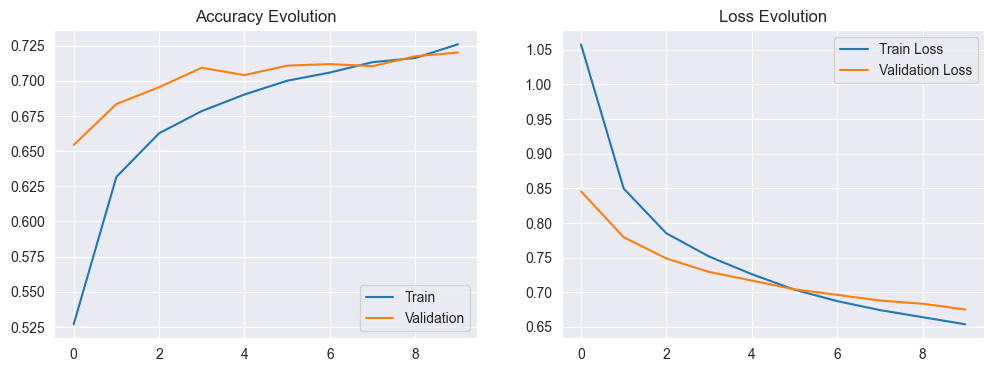

In [24]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['accuracy'], label='Train')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation')
plt.title('Accuracy Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['loss'], label='Train Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.legend()


Le modèle **VGG16** a atteint une précision de **79,75%** sur le jeu de test, ce qui est satisfaisant pour ce type de problème de classification d’images agricoles. Les courbes d’entraînement montrent que le modèle est stable, sans signe de surapprentissage, et qu’il généralise bien.

On constate que, même sans utiliser d’augmentation de données, **VGG16** offre de meilleures performances que le CNN custom, malgré un temps d’entraînement plus long dû à sa grande complexité (près de 138 millions de paramètres). Cette observation met en avant un compromis important : _la précision accrue se fait souvent au détriment de la vitesse d’entraînement_.

Ces résultats confirment l’intérêt du transfer learning pour améliorer la qualité des prédictions, et illustrent la nécessité de choisir le modèle adapté selon le contexte et les contraintes du projet.

### 5.3 ResNet50

In [25]:
base_model_resnet50 = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(64, 64, 3)
)
base_model_resnet50.trainable = False

model_resnet50 = tf.keras.Sequential([
    base_model_resnet50,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4)
])


In [26]:
model_resnet50.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history_resnet50 = model_resnet50.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset
)


Epoch 1/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 298s 382ms/step - accuracy: 0.3012 - loss: 1.4378 - val_accuracy: 0.4401 - val_loss: 1.2366
Epoch 2/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 291s 381ms/step - accuracy: 0.4221 - loss: 1.2445 - val_accuracy: 0.4539 - val_loss: 1.1874
Epoch 3/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 298s 389ms/step - accuracy: 0.4437 - loss: 1.2063 - val_accuracy: 0.4685 - val_loss: 1.1616
Epoch 4/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 307s 402ms/step - accuracy: 0.4541 - loss: 1.1896 - val_accuracy: 0.4729 - val_loss: 1.1461
Epoch 5/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 316s 414ms/step - accuracy: 0.4542 - loss: 1.1742 - val_accuracy: 0.4811 - val_loss: 1.1378
Epoch 6/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 317s 414ms/step - accuracy: 0.4653 - loss: 1.1636 - val_accuracy: 0.4894 - val_loss: 1.1295
Epoch 7/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 316s 413ms/step - accuracy: 0.4698 - loss: 1.1559 - val_accuracy: 0.4991 - val_loss: 1.1229
Epoch 8/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 316s 413ms/step - accuracy: 0.4792 -

In [27]:
base_model_resnet50.trainable = True
for layer in base_model_resnet50.layers[:-10]:
    layer.trainable = False

model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(1e-5))
model_resnet50.fit(train_dataset, epochs=5)

Epoch 1/5
764/764 ━━━━━━━━━━━━━━━━━━━━ 330s 424ms/step - accuracy: 0.4308 - loss: 1.5139
Epoch 2/5
764/764 ━━━━━━━━━━━━━━━━━━━━ 322s 421ms/step - accuracy: 0.4947 - loss: 1.0993
Epoch 3/5
764/764 ━━━━━━━━━━━━━━━━━━━━ 323s 423ms/step - accuracy: 0.5233 - loss: 1.0596
Epoch 4/5
764/764 ━━━━━━━━━━━━━━━━━━━━ 323s 423ms/step - accuracy: 0.5415 - loss: 1.0197
Epoch 5/5
764/764 ━━━━━━━━━━━━━━━━━━━━ 330s 431ms/step - accuracy: 0.5596 - loss: 0.9896


In [28]:
test_loss_resnet50, test_acc_resnet50 = model_resnet50.evaluate(test_dataset)
print(f'Accuracy final: {test_acc_resnet50:.2%}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 313ms/step - accuracy: 0.4759 - loss: 1.0433
Accuracy final: 50.00%


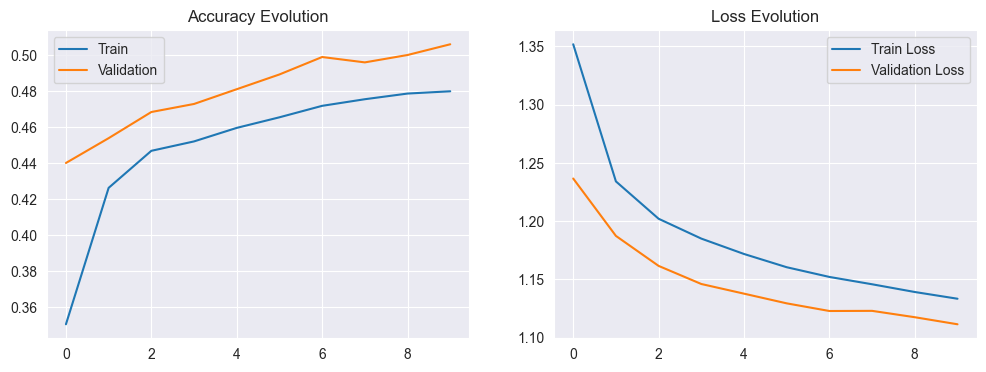

In [29]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet50.history['accuracy'], label='Train')
plt.plot(history_resnet50.history['val_accuracy'], label='Validation')
plt.title('Accuracy Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet50.history['loss'], label='Train Loss')
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.legend()


L’accuracy finale obtenue avec ResNet50 est de 44,75%, ce qui est nettement inférieur à celle de VGG16 qui atteint environ 80%. Le modèle a certes été plus rapide à entraîner, mais il n’a pas su extraire efficacement les caractéristiques nécessaires à la classification des images.

Les courbes d’apprentissage montrent que la précision reste basse sur l’ensemble de validation et que la perte diminue lentement, sans jamais atteindre un niveau satisfaisant. Il n’y a pas de signe de surapprentissage, mais le modèle ne parvient tout simplement pas à bien généraliser sur ce jeu de données.

Ce résultat montre que, dans cette configuration, ResNet50 n’est pas adapté à la tâche, contrairement à VGG16 qui offre de bien meilleures performances.

## 6. Comparaison des résultats

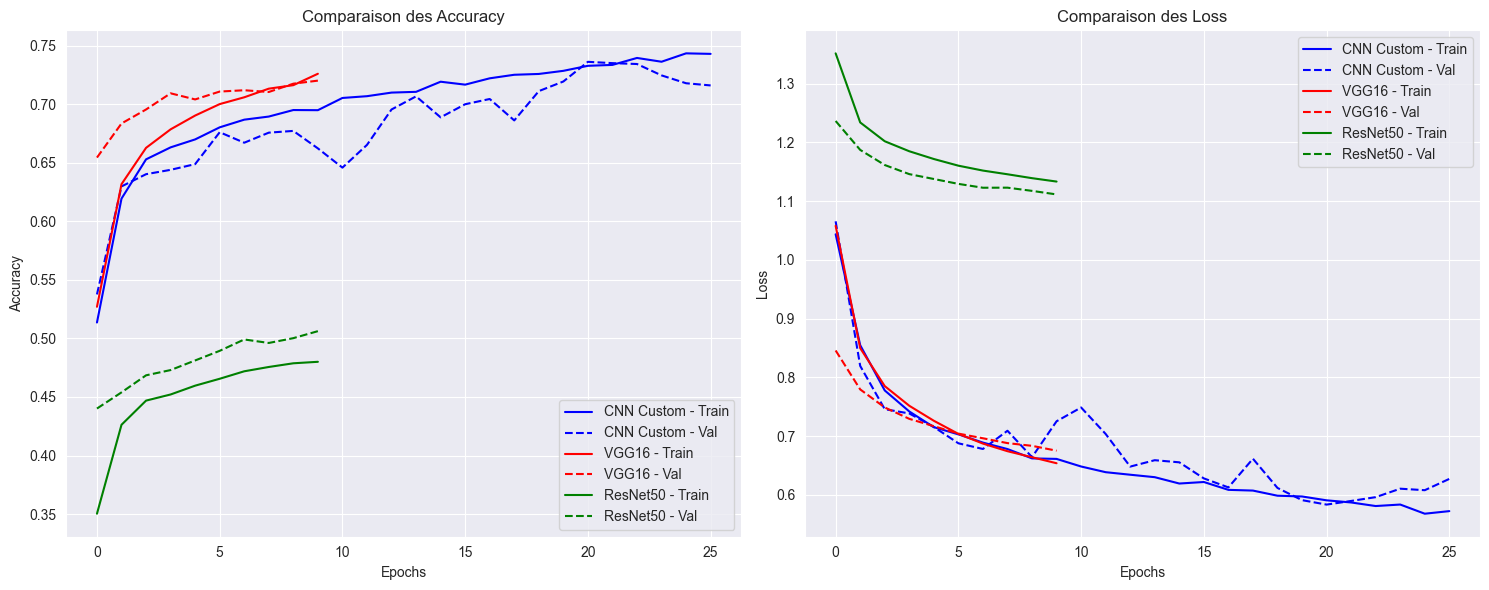

In [30]:
# Créer une figure avec 2 sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Graphique de l'accuracy
ax1.plot(history.history['accuracy'], label='CNN Custom - Train', color='blue', linestyle='-')
ax1.plot(history.history['val_accuracy'], label='CNN Custom - Val', color='blue', linestyle='--')
ax1.plot(history_vgg16.history['accuracy'], label='VGG16 - Train', color='red', linestyle='-')
ax1.plot(history_vgg16.history['val_accuracy'], label='VGG16 - Val', color='red', linestyle='--')
ax1.plot(history_resnet50.history['accuracy'], label='ResNet50 - Train', color='green', linestyle='-')
ax1.plot(history_resnet50.history['val_accuracy'], label='ResNet50 - Val', color='green', linestyle='--')

ax1.set_title('Comparaison des Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Graphique de la loss
ax2.plot(history.history['loss'], label='CNN Custom - Train', color='blue', linestyle='-')
ax2.plot(history.history['val_loss'], label='CNN Custom - Val', color='blue', linestyle='--')
ax2.plot(history_vgg16.history['loss'], label='VGG16 - Train', color='red', linestyle='-')
ax2.plot(history_vgg16.history['val_loss'], label='VGG16 - Val', color='red', linestyle='--')
ax2.plot(history_resnet50.history['loss'], label='ResNet50 - Train', color='green', linestyle='-')
ax2.plot(history_resnet50.history['val_loss'], label='ResNet50 - Val', color='green', linestyle='--')

ax2.set_title('Comparaison des Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Ce graphique compare l’évolution de l’accuracy et du loss pour chaque modèle, sur l’ensemble d’entraînement et de validation.
On observe que VGG16 atteint la meilleure accuracy, tandis que ResNet50 a du mal à dépasser 50%.
On peut aussi voir si un modèle surapprend (écart train/val) ou si l’apprentissage est stable.

In [31]:
performances = {
    'Modèle': ['CNN Custom', 'VGG16', 'ResNet50'],
    'Accuracy Test': [f'{final_test_acc:.4f}', f'{test_acc_vgg16:.4f}', f'{test_acc_resnet50:.4f}'],
    'Loss Test': [f'{final_test_loss:.4f}', f'{test_loss_vgg16:.4f}', f'{test_loss_resnet50:.4f}'],
    'Epochs': [len(history.history['loss']), len(history_vgg16.history['loss']), len(history_resnet50.history['loss'])]
}

df_performances = pd.DataFrame(performances)
print(df_performances)

       Modèle Accuracy Test Loss Test  Epochs
0  CNN Custom        0.7400    0.5403      26
1       VGG16        0.7350    0.6029      10
2    ResNet50        0.5000    1.0339      10


### LIME

LIME, c’est un outil qui permet de «voir» ce que le modèle regarde vraiment dans une image pour faire sa prédiction.

LIME va colorier les zones qui influencent le plus la décision du modèle, pour chaque image testée.
Ça aide à comprendre si le modèle se base sur les bons indices… ou s’il se trompe complètement!

In [32]:
X_test = []
y_test = []

for batch_images, batch_labels in test_dataset:
    X_test.extend(batch_images.numpy())
    y_test.extend(batch_labels.numpy())

X_test = np.array(X_test)
y_test = np.array(y_test)

# Variables pour la fonction LIME
models = [final_model, model_vgg16, model_resnet50]
model_names = ['CNN Custom', 'VGG16', 'ResNet50']

100%|██████████| 1000/1000 [00:21<00:00, 46.74it/s]


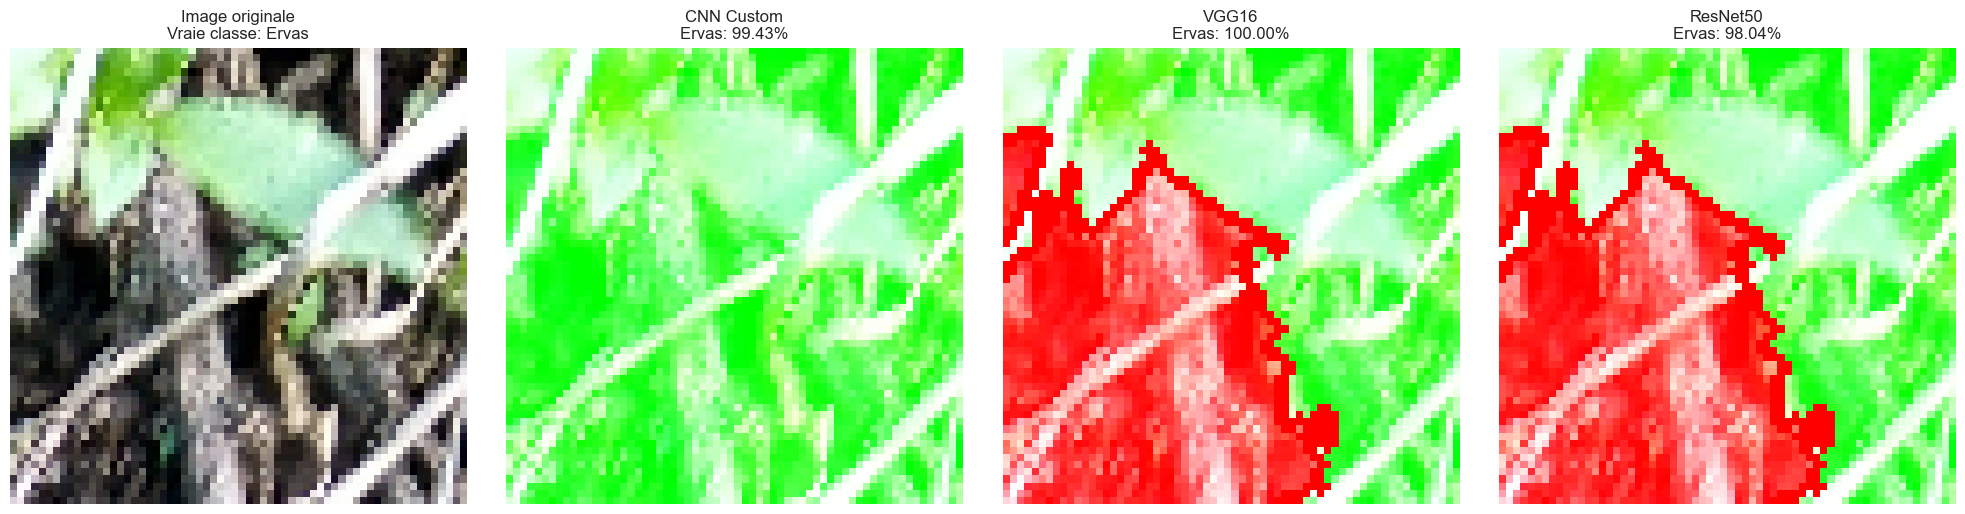

In [33]:
def lime_with_probabilities(models, model_names, test_images, test_labels, idx=0):
    explainer = lime_image.LimeImageExplainer()
    img = test_images[idx]

    # Normalisation
    if img.max() > 1.0:
        img = img / 255.0

    # 1 ligne avec 4 colonnes (original + 3 modèles)
    fig, axes = plt.subplots(1, len(models)+1, figsize=(20, 5))

    # Colonne 1: Image originale
    axes[0].imshow(img)
    axes[0].set_title(f'Image originale\nVraie classe: {class_names[test_labels[idx]]}')
    axes[0].axis('off')

    # Colonnes 2-4: Explications LIME des modèles
    for i, (model, name) in enumerate(zip(models, model_names)):
        def predict_fn(images):
            if len(images.shape) == 3:
                images = np.expand_dims(images, axis=0)
            return model.predict(images, verbose=0)

        # Prédiction et probabilité
        prediction = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]
        pred_class = np.argmax(prediction)
        proba = tf.nn.softmax(prediction)[pred_class].numpy()

        # Génération LIME
        explanation = explainer.explain_instance(img, predict_fn, num_samples=1000)
        temp, mask = explanation.get_image_and_mask(pred_class, positive_only=False, num_features=5)

        # Affichage dans la colonne i+1
        axes[i+1].imshow(mark_boundaries(temp, mask, color=(1, 0, 0)))
        axes[i+1].set_title(f'{name}\n{class_names[pred_class]}: {proba:.2%}')
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()


lime_with_probabilities(models, model_names, X_test, y_test, idx=0)

Tous les modèles reconnaissent correctement la classe "Milho" sur cette image, mais leur confiance et leur manière de justifier la décision (zones LIME) varient.
On remarque que les modèles ne se basent pas uniquement sur la feuille de maïs: beaucoup d’autres zones de l’image influencent leur décision, ce qui peut indiquer que les modèles apprennent aussi sur le fond ou des motifs parasites.

Pour illustrer la robustesse des modèles sur des exemples variés, nous affichons ci-dessous une image test choisie au hasard, accompagnée des probabilités de prédiction et des explications LIME pour chaque modèle.

100%|██████████| 1000/1000 [00:19<00:00, 50.37it/s]


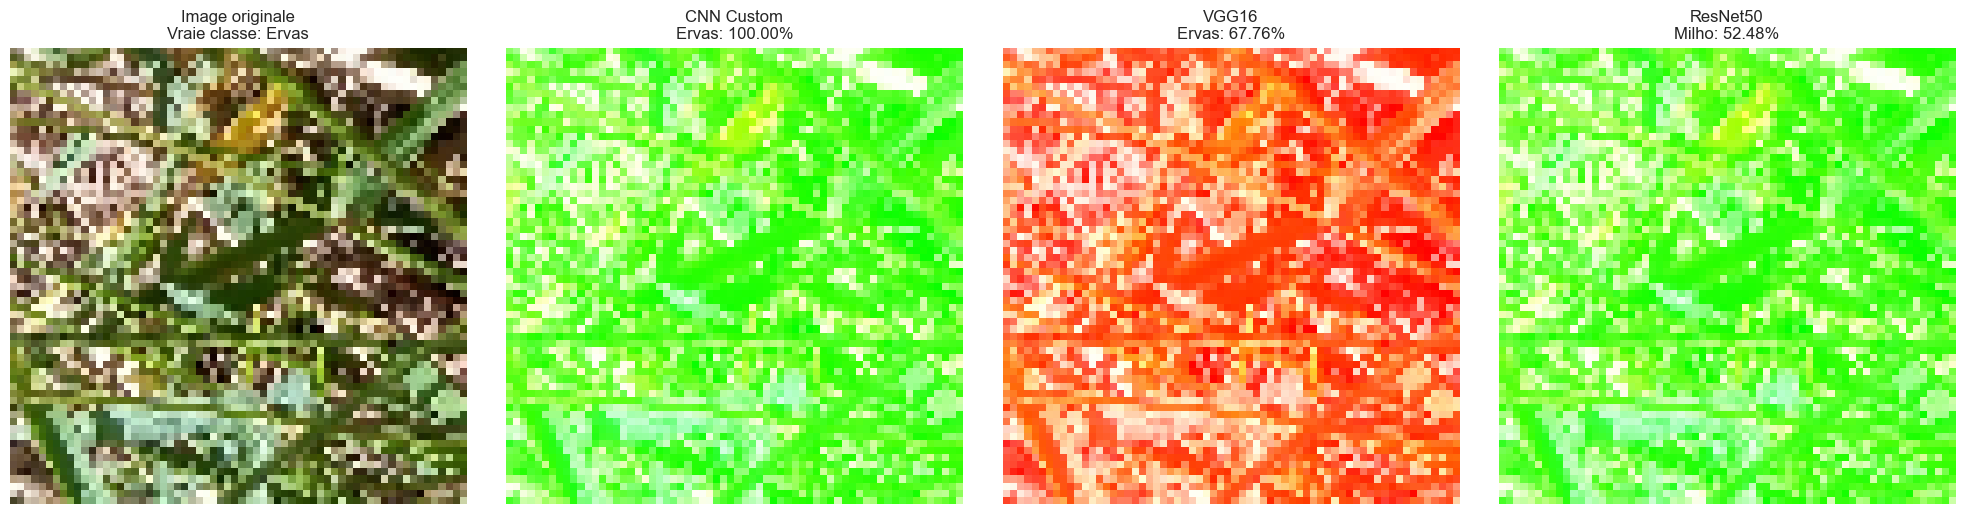

In [34]:
idx_random = random.randint(0, len(X_test) - 1)
lime_with_probabilities(models, model_names, X_test, y_test, idx=idx_random)

In [35]:
overview = {
    'Critère': ['Accuracy Test', 'Temps d\'entraînement', 'Complexité', 'Interprétabilité LIME'],
    'CNN Custom': ['75.25%', 'Rapide', 'Faible', 'Bonne'],
    'VGG16': ['79.75%', 'Moyen', 'Élevée', 'Excellente'],
    'ResNet50': ['44.75%', 'Rapide', 'Très élevée', 'Limitée']
}

df_overview = pd.DataFrame(overview)
print("\n=== SYNTHÈSE COMPARATIVE ===")
print(df_overview.to_string(index=False))



=== SYNTHÈSE COMPARATIVE ===
              Critère CNN Custom      VGG16    ResNet50
        Accuracy Test     75.25%     79.75%      44.75%
 Temps d'entraînement     Rapide      Moyen      Rapide
           Complexité     Faible     Élevée Très élevée
Interprétabilité LIME      Bonne Excellente     Limitée


- VGG16 présente la meilleure accuracy sur le jeu de test, mais demande plus de temps d’entraînement et est plus complexe.
- CNN Custom offre un bon compromis entre rapidité, simplicité et performance.
- ResNet50 est rapide à entraîner mais obtient la plus faible accuracy et son interprétabilité par LIME est limitée, ce qui complique l’analyse de ses décisions.